In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 20
epsilon_std = 1.0


In [3]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [4]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


W0308 20:12:13.134845 140360757179904 deprecation.py:323] From /home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.


In [6]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)


W0308 20:12:17.043483 140360757179904 deprecation_wrapper.py:119] From /home/ishanu/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 80us/step - loss: 191.2722 - val_loss: 172.3784
Epoch 2/10
60000/60000 [==============================] - 5s 77us/step - loss: 169.9540 - val_loss: 167.7846
Epoch 3/10
60000/60000 [==============================] - 5s 78us/step - loss: 166.7958 - val_loss: 165.6120
Epoch 4/10
60000/60000 [==============================] - 5s 83us/step - loss: 164.7603 - val_loss: 164.0337
Epoch 5/10
60000/60000 [==============================] - 5s 85us/step - loss: 163.1915 - val_loss: 162.8409
Epoch 6/10
60000/60000 [==============================] - 5s 85us/step - loss: 161.8594 - val_loss: 161.3259
Epoch 7/10
60000/60000 [==============================] - 5s 86us/step - loss: 160.6727 - val_loss: 160.4524
Epoch 8/10
60000/60000 [==============================] - 5s 87us/step - loss: 159.6222 - val_loss: 159.1967
Epoch 9/10
60000/60000 [==============================] - 5s 87us/step - loss:

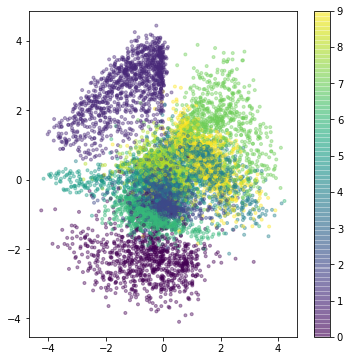

In [7]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()


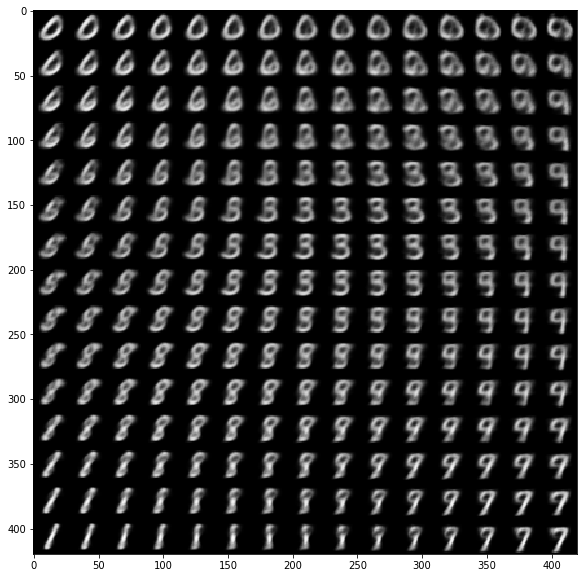

In [8]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')


In [19]:
val=[-.2,.5]

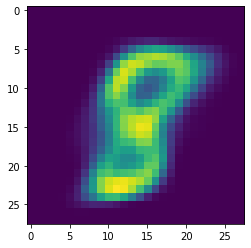

In [20]:
plt.imshow(decoder.predict(np.array(val).reshape(1,2)).reshape(digit_size, digit_size))